[View in Colaboratory](https://colab.research.google.com/github/rex-yue-wu/Notebooks/blob/master/forceSparseWeights.ipynb)

In [0]:
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np 
from keras.layers import Input, Conv1D, Conv3D, SimpleRNN, Conv2D, Reshape, Permute, TimeDistributed
from keras.models import Model
from keras.constraints import Constraint
from keras.callbacks import Callback
from matplotlib import pyplot
from copy import deepcopy

# Define our custom constraints to force small weights to zeros 
# and callbacks to monitor weight sparsity

In [0]:
class NoSmallWeights(Constraint) :
    def __init__(self, th_val=1e-3 ):
        self.th_val = th_val
    def __call__(self, w):
        w *= K.cast(K.greater_equal(w, self.th_val), K.floatx())
        return w        

class ShowSparsity( Callback ) :
    def __init__( self, th_val=1e-3 ) :
        self.th_val = th_val
    def on_epoch_end( self, epoch, logs ) :
        w_list = self.model.get_weights()
        w_list = sum( [], w_list )
        denominator = 0.
        numerator = 0.
        for w in w_list :
            if w.ndim > 1 :
                denominator += w.size
                numerator += np.sum( w < self.th_val )
        print "Epoch {:05d}, sparsity = {:.4f}".format( epoch, numerator/denominator )
            

# Use MNIST as an exmaple

In [3]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

('X_train original shape', (60000, 28, 28))
('y_train original shape', (60000,))
('Training matrix shape', (60000, 784))
('Testing matrix shape', (10000, 784))


# Define a testing network architecture

- support l1 regularization
- support forcing small weights to zeros during training

## NOTE: this network architecture is NOT optimal, but we only use it to demonstrate the idea.

In [0]:
from keras.regularizers import l1
def create_model( th_val, l1_coef=0 ) :
    
    smodel = Sequential()
    smodel.add(Dense(512, input_shape=(784,), use_bias=False,
               kernel_constraint = NoSmallWeights(th_val) if (th_val is not None) else None, 
               kernel_regularizer=l1(l1_coef)))
    smodel.add(Activation('tanh'))
    smodel.add(Dropout(0.2))  
    smodel.add(Dense(512, use_bias=False,      
               kernel_constraint=NoSmallWeights(th_val) if (th_val is not None) else None, 
               kernel_regularizer=l1(l1_coef)))
    smodel.add(Activation('tanh'))
    smodel.add(Dropout(0.2))
    smodel.add(Dense(10, use_bias=False, 
               kernel_constraint=NoSmallWeights(th_val) if (th_val is not None) else None, 
               kernel_regularizer=l1(l1_coef)))
    smodel.add(Activation('softmax')) 
    smodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return smodel

In [5]:
all_model_weights = []
th_val_list = [None, 0, 1e-5, 1e-4, 1e-3, 1e-2 ]
for th_val in th_val_list :
    print "-" * 50
    print "th_val =", th_val
    print "-" * 50
    smodel = create_model( th_val, l1_coef=1e-4 )
    smodel.fit(X_train, Y_train,
              batch_size=128, nb_epoch=5,
              verbose=0, callbacks=[ShowSparsity((th_val or 0) +K.epsilon())],
              validation_data=(X_test, Y_test))
    print "testing accuracy =", smodel.evaluate( X_test, Y_test, verbose=0 )[1]
    all_model_weights.append( smodel.get_weights() )

--------------------------------------------------
th_val = None
--------------------------------------------------


/usr/local/lib/python2.7/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 00000, sparsity = 0.5033
Epoch 00001, sparsity = 0.5007
Epoch 00002, sparsity = 0.5005
Epoch 00003, sparsity = 0.5016
Epoch 00004, sparsity = 0.5003
testing accuracy = 0.9599
--------------------------------------------------
th_val = 0
--------------------------------------------------
Epoch 00000, sparsity = 0.8736
Epoch 00001, sparsity = 0.8729
Epoch 00002, sparsity = 0.8530
Epoch 00003, sparsity = 0.8476
Epoch 00004, sparsity = 0.8457
testing accuracy = 0.9309
--------------------------------------------------
th_val = 1e-05
--------------------------------------------------
Epoch 00000, sparsity = 0.8738
Epoch 00001, sparsity = 0.8611
Epoch 00002, sparsity = 0.8653
Epoch 00003, sparsity = 0.8621
Epoch 00004, sparsity = 0.8369
testing accuracy = 0.9312
--------------------------------------------------
th_val = 0.0001
--------------------------------------------------
Epoch 00000, sparsity = 0.8804
Epoch 00001, sparsity = 0.8813
Epoch 00002, sparsity = 0.8729
Epoch 00003, spa

# Evaluate model performance before and after setting small weights to zero

In [0]:
def set_small_weights_zeros( w_list, th_val ) :
    denominator = 0.
    numerator = 0.
    for w in w_list :
        denominator += w.size
        numerator += np.sum(w<th_val)
        w[w<th_val] = 0.
    return numerator/denominator
        

([<matplotlib.axis.XTick at 0x7fc5462b9190>,
 <a list of 6 Text xticklabel objects>)

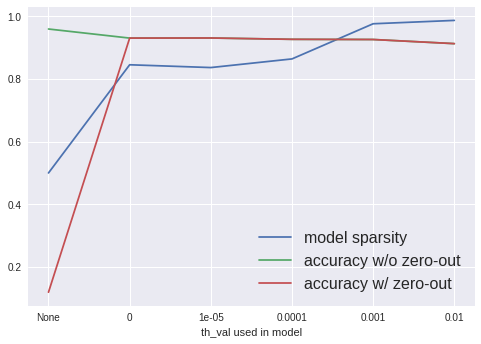

In [9]:
results = []
for w_list in all_model_weights :
    # evaluate model before setting small weights to zeros
    smodel.set_weights( w_list )
    loss, acc =  smodel.evaluate( X_test, Y_test, verbose=0 )
    # set small weights to zeros and compute sparisty
    w0_list = deepcopy(w_list)
    sparsity = set_small_weights_zeros( w0_list, th_val=K.epsilon() )
    # re-evaluate model after setting small weights to zeros
    smodel.set_weights( w0_list )
    loss0, acc0 =  smodel.evaluate( X_test, Y_test, verbose=0 )
    results.append( [sparsity, acc, acc0] )
    
    
pyplot.plot( np.row_stack( results ) ) 
pyplot.legend(['model sparsity', 'accuracy w/o zero-out', 'accuracy w/ zero-out'], fontsize=16)
pyplot.xlabel( 'th_val used in model')
pyplot.xticks( range(6), [ str(v) for v in th_val_list ] )